In [211]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import nltk
import re
import string
import seaborn as sns
from wordcloud import WordCloud
import spacy
from bs4 import BeautifulSoup
from tqdm import tqdm
tqdm.pandas()

In [212]:
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /home/kro/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/kro/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [213]:
dataStack = pd.read_csv("../QueryResults.csv")
dataStack["CreationDate"] = pd.to_datetime(dataStack["CreationDate"])
dataStack["CreationYear"] = dataStack["CreationDate"].dt.year
dataStack.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23617 entries, 0 to 23616
Data columns (total 24 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   Id                     23617 non-null  int64         
 1   PostTypeId             23617 non-null  int64         
 2   AcceptedAnswerId       20773 non-null  float64       
 3   ParentId               0 non-null      float64       
 4   CreationDate           23617 non-null  datetime64[ns]
 5   DeletionDate           0 non-null      float64       
 6   Score                  23617 non-null  int64         
 7   ViewCount              23617 non-null  int64         
 8   Body                   23617 non-null  object        
 9   OwnerUserId            23043 non-null  float64       
 10  OwnerDisplayName       3989 non-null   object        
 11  LastEditorUserId       21437 non-null  float64       
 12  LastEditorDisplayName  2749 non-null   object        
 13  L

In [214]:
dataStack.head()

,Id,PostTypeId,AcceptedAnswerId,ParentId,CreationDate,DeletionDate,Score,ViewCount,Body,OwnerUserId,...,LastActivityDate,Title,Tags,AnswerCount,CommentCount,FavoriteCount,ClosedDate,CommunityOwnedDate,ContentLicense,CreationYear
0,7284,1,7320.0,NaN,2008-08-10 18:41:02,NaN,559,207501,"<p>What does the expression ""Turing Complete"" ...",198.0,...,2021-04-10 17:47:05,What is Turing Complete?,<theory><turing-machines><turing-complete>,15,1,182,NaN,NaN,CC BY-SA 3.0,2008
1,7477,1,7523.0,NaN,2008-08-11 01:43:13,NaN,123,145744,<p>I'm currently working on an internal sales ...,841.0,...,2020-03-09 14:10:06,How to autosize a textarea using Prototype?,<javascript><html><css><textarea><prototypejs>,18,4,67,NaN,NaN,CC BY-SA 4.0,2008
2,7492,1,NaN,NaN,2008-08-11 03:00:26,NaN,246,160754,"<p>In the past, I used Microsoft Web Applicati...",556.0,...,2018-08-30 15:01:26,Performing a Stress Test on Web Application?,<web-applications><stress-testing><performance...,30,0,174,NaN,NaN,CC BY-SA 3.0,2008
3,17732,1,NaN,NaN,2008-08-20 11:01:19,NaN,175,59340,"<p>There's a <a href=""http://groups.google.com...",2095.0,...,2020-10-16 17:24:22,When should assertions stay in production code?,<assert>,17,1,60,2020-03-24 06:04:04,2010-06-10 14:39:45,CC BY-SA 2.5,2008
4,17806,1,2137718.0,NaN,2008-08-20 12:00:59,NaN,340,194826,<p>I am currently developing a .NET applicatio...,2078.0,...,2021-05-26 18:59:42,Warning: Found conflicts between different ver...,<.net><warnings>,19,0,64,NaN,NaN,CC BY-SA 4.0,2008


<AxesSubplot:title={'center':'Evolution des questions'}, xlabel='Année', ylabel='Nombre de questions'>

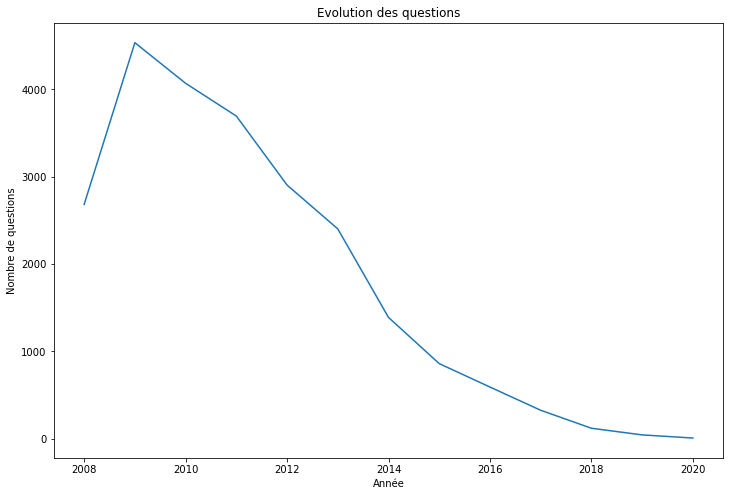

In [215]:
dataTemp = dataStack.groupby(by="CreationYear").count()
dataTemp = dataTemp.iloc[:,0]
fig = plt.figure(figsize=(20, 8))
dataTemp.plot(figsize=(12,8),
          title="Evolution des questions",
          ylabel="Nombre de questions",
          xlabel="Année",
          legend=False)

# Fonctions

In [216]:
def getListTag(listToWork,sep,years="All"):
    """ 
    Fonction qui compte le nombre de mots différents
    listToWork : Dataframe
    sep : Séparateur pour spliter
    years : l'année pour laquelle on travaille
    """
    tagList=[]
    tempData = dataStack.copy()
    
    if years != "All":
        tempData = tempData[tempData['CreationYear']==years]
    for tags in tempData[listToWork]:
        for mot in tags.split(sep):
            tagList.append(mot)
            
    dfTagList = pd.DataFrame(tagList, columns=["Tag"])
    dfTagList = dfTagList.groupby("Tag")\
        .agg(tagCount=pd.NamedAgg(column="Tag", aggfunc="count"))
    dfTagList.sort_values("tagCount", ascending=False, inplace=True)

    return dfTagList

In [217]:
def keep_info(listInfo,toKeep):
    """Return the list of information which is in the 'keep list'"""
    loc = []
    try:
        if listInfo != 'nan':
            for word in listInfo.split(','):
                if word in toKeep.index:
                    loc.append(word)
    except:
        print("Except ",listInfo)
    return ','.join(loc)

In [218]:
def nettoyageGe(listToClean):
    
    # Lower case
    locList = listToClean.lower()

    # Remove ponctuation sauf #
    locList = re.sub('[^\\w\\s#]', '', locList)
    # Remove digit
    locList = re.sub(r'\w*\d+\w*', '', locList)
    # Remove links
    locList = re.sub(r'http*\S+', '', locList)
    # Remove \n
    locList = locList.replace("\n"," ")
    # Change some words
    locList = locList.replace("i'm","i am")
    locList = locList.replace("i've","i have")
    locList = locList.replace("i'd","i would")
    locList = locList.replace("don't","do not")
    locList = locList.replace("c #","c#")
    
    return(locList)

In [219]:
def getWord(listToWork):
    """ 
    Fonction qui compte le nombre de mots différents
    listToWork : Dataframe
    """
    motList=[]
    tempData = dataStack[listToWork].copy()
    
    for listData in tempData:
        for mot in listData:
            motList.append(mot)
            
    dfMotList = pd.DataFrame(motList, columns=["Mot"])
    dfMotList = dfMotList.groupby("Mot")\
        .agg(Count=pd.NamedAgg(column="Mot", aggfunc="count"))
    dfMotList.sort_values("Count", ascending=False, inplace=True)
    
    return dfMotList

# Tags

In [220]:
dataStack['MainTags']=dataStack['Tags'].str.replace("<","")
dataStack['MainTags']=dataStack['MainTags'].str.replace(">",",")
dataStack['MainTags']=dataStack['MainTags'].str[:-1]

In [221]:
listTags = getListTag('MainTags',',')
#listTags

In [222]:
#On garde les 40 plus utilisés
listTags=listTags.iloc[:40]
#listTags

<Figure size 1080x720 with 0 Axes>

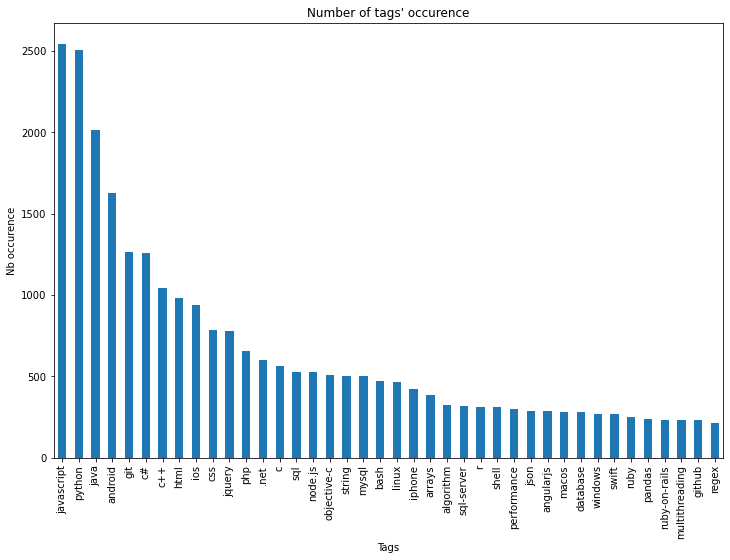

In [223]:
fig = plt.figure(figsize=(15, 10))

listTags.plot(figsize=(12,8), kind="bar",
          title="Number of tags' occurence",
          ylabel="Nb occurence",
          xlabel="Tags",
          legend=False)
plt.xticks(np.arange(len(listTags)),listTags.index)
plt.show()

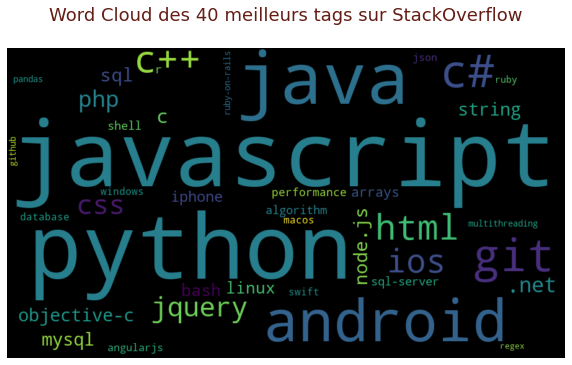

In [224]:
# Word cloud 
fig = plt.figure(1, figsize=(10, 8))
ax = fig.add_subplot(1, 1, 1)
wordcloud = WordCloud(width=900, height=500,
                      background_color="black",
                      max_words=500, relative_scaling=1,
                      normalize_plurals=False)\
    .generate_from_frequencies(listTags.to_dict()['tagCount'])

ax.imshow(wordcloud, interpolation='bilinear')
ax.axis("off")
plt.title("Word Cloud des 40 meilleurs tags sur StackOverflow\n",
          fontsize=18, color="#641E16")
plt.show()

In [225]:
# keep top 40 tags
dataStack['MainTags']=dataStack['MainTags'].apply(lambda x : keep_info(x,listTags))

In [226]:
# On garde ceux qui ont des tags
dataStack=dataStack[dataStack['MainTags']!=""]

In [228]:
dataStack['MainTags']= dataStack['MainTags'].str.replace(',',' ')

In [229]:
dataStack['MainTags'].head()

1    javascript html css
2            performance
4                   .net
5         c# c++ windows
6                 python
Name: MainTags, dtype: object

In [230]:
# Tokenization
dataStack['MainTags'] = dataStack['MainTags'].apply(nltk.tokenize.word_tokenize)

# Title

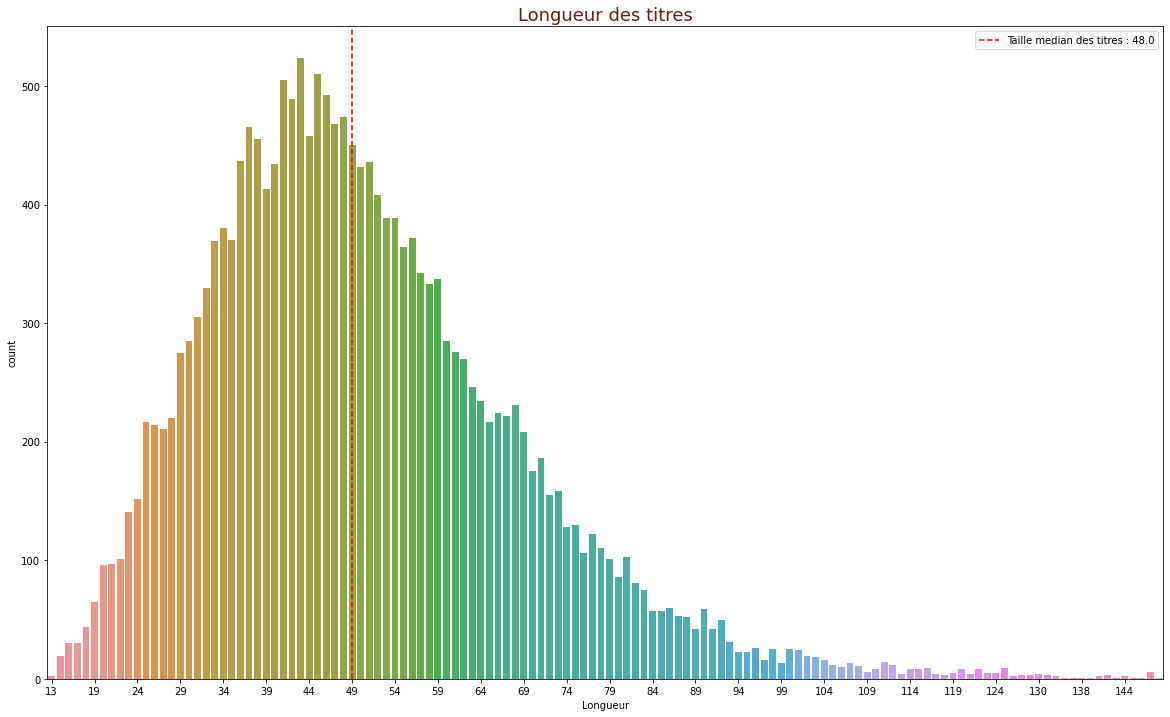

In [231]:
fig = plt.figure(figsize=(20, 12))
ax = sns.countplot(x=dataStack.Title.str.len())
start, end = ax.get_xlim()
ax.xaxis.set_ticks(np.arange(0, end, 5))
plt.axvline(dataStack.Title.str.len().median() - dataStack.Title.str.len().min(),
            color="r", linestyle='--',
            label="Taille median des titres : "+str(dataStack.Title.str.len().median()))
ax.set_xlabel("Longueur")
plt.title("Longueur des titres",
          fontsize=18, color="#641E16")
plt.legend()
plt.show()

In [232]:
dataStack['MainWordTitle'] = dataStack['Title'].progress_apply(lambda x : nettoyageGe(x))

100%|██████████| 19393/19393 [00:00<00:00, 107796.96it/s]


In [233]:
dataStack['Title'].head()

1          How to autosize a textarea using Prototype?
2         Performing a Stress Test on Web Application?
4    Warning: Found conflicts between different ver...
5    Can I get Memcached running on a Windows (x64)...
6                   Accessing MP3 metadata with Python
Name: Title, dtype: object

In [234]:
dataStack['MainWordTitle'].head(20)

1            how to autosize a textarea using prototype
2           performing a stress test on web application
4     warning found conflicts between different vers...
5     can i get memcached running on a windows   env...
6                       accessing  metadata with python
7                           what ruby ide do you prefer
9                when to use ilist and when to use list
10    what tools do you use to develop c application...
11    getting ssh to execute a command in the backgr...
12    what are the differences between delegates and...
13    what are the differences between a hashmap and...
14               is java passbyreference or passbyvalue
15    how do i get the full url of the page i am on ...
16    what is the best way to give a c# autoproperty...
17    easy way to write contents of a java inputstre...
19    tsql stored procedure that accepts multiple id...
20                     comparing two byte arrays in net
21    what is the most effective way for float a

In [235]:
nlp = spacy.load('en_core_web_sm')
pos_list = ["NOUN","PROPN"]

In [236]:
# On garde nom et prono
def keepNomEtPronom(info):
    doc = nlp(info)
    list_text_row = []
    for token in doc:
        if(token.pos_ in pos_list):
            list_text_row.append(token.text)
    list_text = " ".join(list_text_row)
    list_text = list_text.replace("c #", "c#")
    list_text_row = []
    return list_text

In [237]:
dataStack['MainWordTitle'] = dataStack['MainWordTitle'].progress_apply(lambda x : keepNomEtPronom(x))

100%|██████████| 19393/19393 [01:05<00:00, 297.80it/s]


In [238]:
dataStack['MainWordTitle'].head(20)

1                           textarea prototype
2                  stress test web application
4          warning conflicts versions assembly
5                          windows environment
6                              metadata python
7                                     ruby ide
9                                   ilist list
10                  tools c applications linux
11       ssh command background target machine
12                differences delegates events
13               differences hashmap hashtable
14                             passbyreference
15                                 url page c#
16                   way c# autoproperty value
17       way contents inputstream outputstream
19                        procedure i d values
20                                 byte arrays
21                        way float comparison
22    file email attachment linux command line
23                        gui designer eclipse
Name: MainWordTitle, dtype: object

In [239]:
# Tokenization
dataStack['MainWordTitle'] = dataStack['MainWordTitle'].apply(nltk.tokenize.word_tokenize)

In [240]:
dataStack['MainWordTitle'].head(20)

1                               [textarea, prototype]
2                    [stress, test, web, application]
4            [warning, conflicts, versions, assembly]
5                              [windows, environment]
6                                  [metadata, python]
7                                         [ruby, ide]
9                                       [ilist, list]
10                    [tools, c, applications, linux]
11        [ssh, command, background, target, machine]
12                   [differences, delegates, events]
13                  [differences, hashmap, hashtable]
14                                  [passbyreference]
15                                  [url, page, c, #]
16                   [way, c, #, autoproperty, value]
17         [way, contents, inputstream, outputstream]
19                          [procedure, i, d, values]
20                                     [byte, arrays]
21                           [way, float, comparison]
22    [file, email, attachme

In [241]:
# Lemmatizer
wn = nltk.WordNetLemmatizer()
dataStack['MainWordTitle'] = dataStack['MainWordTitle'].apply(lambda x : [wn.lemmatize(word) for word in x])

In [242]:
dataStack['MainWordTitle'].head(20)

1                               [textarea, prototype]
2                    [stress, test, web, application]
4              [warning, conflict, version, assembly]
5                               [window, environment]
6                                  [metadata, python]
7                                         [ruby, ide]
9                                       [ilist, list]
10                      [tool, c, application, linux]
11        [ssh, command, background, target, machine]
12                      [difference, delegate, event]
13                   [difference, hashmap, hashtable]
14                                  [passbyreference]
15                                  [url, page, c, #]
16                   [way, c, #, autoproperty, value]
17          [way, content, inputstream, outputstream]
19                           [procedure, i, d, value]
20                                      [byte, array]
21                           [way, float, comparison]
22    [file, email, attachme

In [243]:
# StopWords
sw = set()
sw.update(tuple(nltk.corpus.stopwords.words('english')))

dataStack['MainWordTitle'] = dataStack['MainWordTitle'].apply(lambda x : [mot for mot in x
                       if mot not in sw])

In [244]:
listTitle = getWord('MainWordTitle')

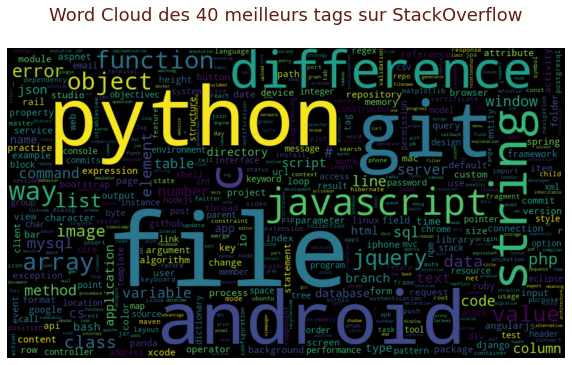

In [245]:
# Word cloud 
fig = plt.figure(1, figsize=(10, 8))
ax = fig.add_subplot(1, 1, 1)
wordcloud = WordCloud(width=900, height=500,
                      background_color="black",
                      max_words=500, relative_scaling=1,
                      normalize_plurals=False)\
    .generate_from_frequencies(listTitle.to_dict()['Count'])

ax.imshow(wordcloud, interpolation='bilinear')
ax.axis("off")
plt.title("Word Cloud des 40 meilleurs tags sur StackOverflow\n",
          fontsize=18, color="#641E16")
plt.show()

# Body

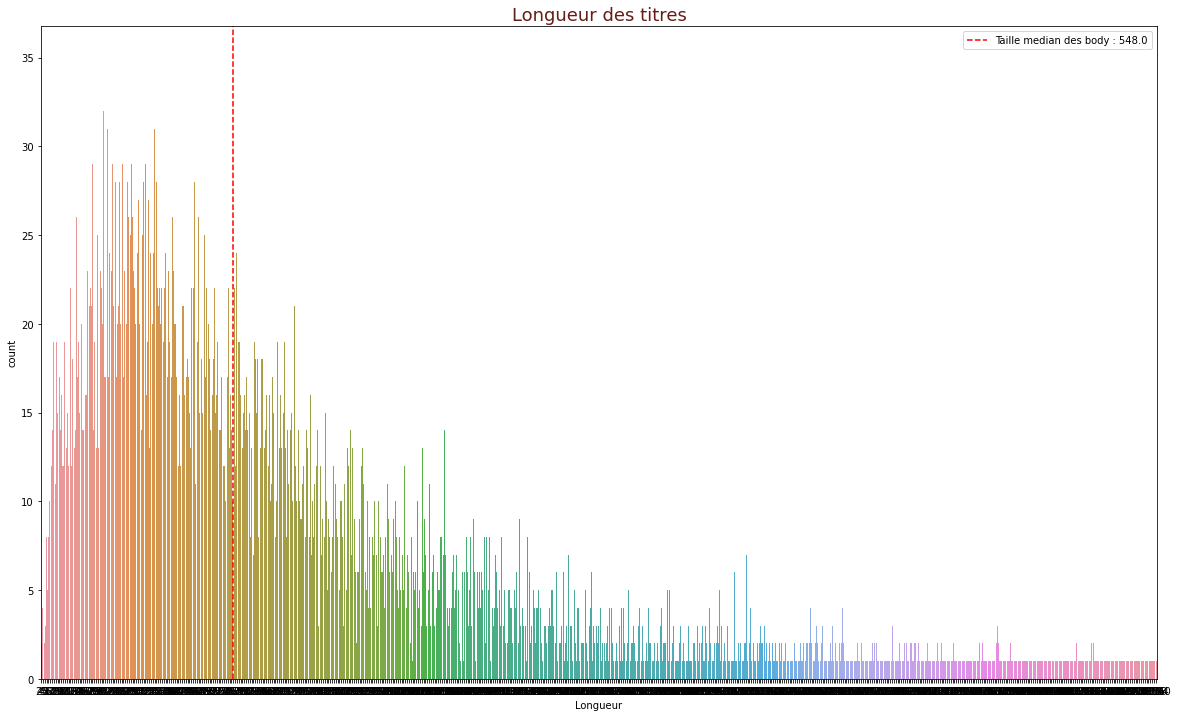

In [246]:
fig = plt.figure(figsize=(20, 12))
ax = sns.countplot(x=dataStack.Body.str.len())
start, end = ax.get_xlim()
ax.xaxis.set_ticks(np.arange(0, end, 5))
plt.axvline(dataStack.Body.str.len().median() - dataStack.Body.str.len().min(),
            color="r", linestyle='--',
            label="Taille median des body : "+str(dataStack.Body.str.len().median()))
ax.set_xlabel("Longueur")
plt.title("Longueur des titres",
          fontsize=18, color="#641E16")
plt.legend()
plt.show()

In [247]:
# Supprimer les tag <code>
def SuppCode(x):
    soup = BeautifulSoup(x,"html.parser")
    code_to_remove = soup.findAll("code")
    for code in code_to_remove:
        code.replace_with(" ")
    return str(soup)

In [248]:
# Delete htlm et code tags
dataStack['MainWordBody'] = dataStack['Body'].apply(SuppCode)
# Delete all html tags
dataStack['MainWordBody'] = [BeautifulSoup(text,"html.parser").get_text() for text in dataStack['MainWordBody']]

#Nettoyage général
dataStack['MainWordBody'] = dataStack['MainWordBody'].progress_apply(lambda x : nettoyageGe(x))

100%|██████████| 19393/19393 [00:01<00:00, 18990.34it/s]


In [249]:
dataStack['MainWordBody'] = dataStack['MainWordBody'].progress_apply(lambda x : keepNomEtPronom(x))
# Tokenization
dataStack['MainWordBody'] = dataStack['MainWordBody'].apply(nltk.tokenize.word_tokenize)
# Lemmatizer
wn = nltk.WordNetLemmatizer()
dataStack['MainWordBody'] = dataStack['MainWordBody'].apply(lambda x : [wn.lemmatize(word) for word in x])

100%|██████████| 19393/19393 [02:50<00:00, 113.68it/s]


In [250]:
# StopWords
sw = set()
sw.update(tuple(nltk.corpus.stopwords.words('english')))

dataStack['MainWordBody'] = dataStack['MainWordBody'].apply(lambda x : [mot for mot in x
                       if mot not in sw])

In [251]:
listBody = getWord('MainWordBody')

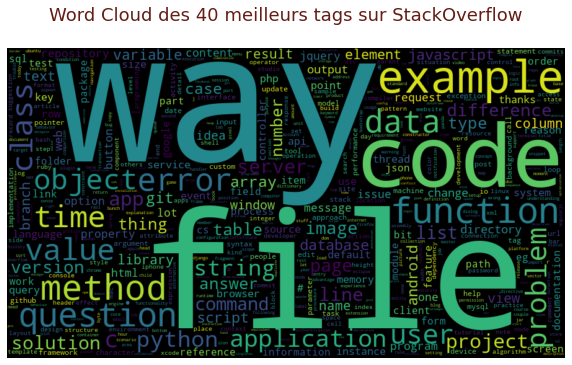

In [252]:
# Word cloud 
fig = plt.figure(1, figsize=(10, 8))
ax = fig.add_subplot(1, 1, 1)
wordcloud = WordCloud(width=900, height=500,
                      background_color="black",
                      max_words=500, relative_scaling=1,
                      normalize_plurals=False)\
    .generate_from_frequencies(listBody.to_dict()['Count'])

ax.imshow(wordcloud, interpolation='bilinear')
ax.axis("off")
plt.title("Word Cloud des 40 meilleurs tags sur StackOverflow\n",
          fontsize=18, color="#641E16")
plt.show()

# Data saved

In [253]:
dataStack[['Id','MainTags','MainWordBody','MainWordTitle']].to_csv("../QueryResults_Clear.csv",index=False)